# arbitrary-depth, arbitrary-width feedforward artificial neural network

see description & style notes in top-level repository `README.md`

In [1]:
# set path
import sys, os
# demo .. fann .. foggy_ml .. foggy-ml
sys.path.append(os.path.abspath(os.path.join("..", "..", "..")))
# project source code
import foggy_ml.util as util
import foggy_ml.fann as fann  # homebrew implementation

# syntax utils
from typing import Tuple, Dict, Callable, Union
# data loading
import sklearn.datasets as datasets
# data structures
import pandas as pd
# data wrangling
from sklearn.preprocessing import StandardScaler as FeatureScaler
# calculations and algorithms
import numpy as np
from sklearn.neural_network import MLPClassifier as RefNN  # reference implementation
# visualization
import matplotlib.pyplot as plt

# utility functions

these just wrangle data into the various formats expected by us, `sklearn`, `matplotlib`, etc, it's not important to read every single line of every single one

In [2]:
NUM_FEATURES: int = 2  # aka num of neurons on input layer
NUM_CATEGORIES: int = 2  # aka num of neurons on output layer
LAYER_SZ: Tuple[int] = (4, 3)  # first hidden layer has 4 neurons, second hidden layer has 3 neurons


def lrange(*args) -> list:
    return list(range(*args))


def titlefy(d: str) -> str:
    # e.g. "train" -> "TRAINING DATA"
    return "{d}ing Data".format(d=d).upper()


def gen_data(n: int=256, noise: float=0.32, random_seed: int=1337, x_scaler: object=None) ->\
    (Dict[str, Union[pd.DataFrame, pd.Series]], object):
    X, y = datasets.make_moons(n_samples=n, noise=noise, random_state=random_seed)
    assert X.shape[1] == NUM_FEATURES, (len(X), NUM_FEATURES)
    assert len(set(y)) == NUM_CATEGORIES, (len(set(y)), NUM_CATEGORIES)
    x_scaler = FeatureScaler().fit(X) if x_scaler is None else x_scaler
    X = x_scaler.transform(X)
    X = pd.DataFrame(X)
    y = pd.Series(y)
    data = {"X": X, "y": y}
    return data, x_scaler


def homebrewify(ref_nn: RefNN, layer_sz: Tuple[float]=LAYER_SZ) -> fann.NN:
    """Reformat reference implementation weights data structure as homebrew."""
    # hidden layers
    hidden_layers = []
    # init: in 1st iteration, each neuron on input layer will get weighted & fed into each neuron on 1st hidden layer
    prev_neuron_indices = lrange(NUM_FEATURES)
    for l, sz in enumerate(layer_sz):
        curr_neuron_indices = lrange(sz)
        del sz
        layer = fann.Layer(index=curr_neuron_indices, columns=[fann.BIAS_INDEX] + prev_neuron_indices)
        # populate bias weights
        layer.loc[:, fann.BIAS_INDEX] = ref_nn.intercepts_[l]
        # populate non-bias weights
        layer.loc[:, prev_neuron_indices] = ref_nn.coefs_[l].T
        del l
        hidden_layers.append(layer.astype(float))
        del layer
        # in next iteration, each neuron on this layer will get weighted & fed into each neuron on next layer
        prev_neuron_indices = curr_neuron_indices
        del curr_neuron_indices
    del layer_sz

    # output layer
    """
    We use 2 output neurons & predict category label
    (0 or 1) based on whose activation is stronger..
    sklearn uses single output neuron & predicts category label
    (0 or 1) based on whether its activation < or >= 0.50.

    Therefore, in replicating sklearn's model, we make
    our zeroth output neuron a dummy whose
    (both bias & non-bias) weights are the negative of
    our first output neuron's  weights, which are exactly equal
    to sklearn's single output neuron's weights.
    With this setup, our first output neuron's outgoing activation
    will always exactly match sklearn's single output neuron's
    outgoing activation i.e. the estimated probability that
    the current data point belongs to category 1.

    And what about our zeroth output neuron's outgoing activation?
    We can write a neuron's activation function input as
    `x = b + w'a` where `b` is its bias, `w` is its weight vector,
    and `a` is the previous layer's output.
    And a property of the logistic function is that f(-x) = 1 - f(x).
    Hence, our zeroth output neuron's outgoing activation will be
    f(-b - w'a) = f(-(b + w'a)) = 1 - f(b + w'a) i.e.
    the complement probability of our first output neuron's
    outgoing activation i.e. the estimated probability that
    the current data point belongs to category 0.

    Thus, thanks to our careful bookkeeping, before we squash,
    our output probabilities will exactly match sklearn's.
    This conveniently helps us replicate sklearn's predictions.

    The obvious wrinkle is that we then squash this,
    which isn't an identity transformation here: for example,
    if our pre-squash output is [0, 1] i.e. 100% probability
    that the current data point belongs to category 1, our post-squash
    output will be [0.27, 0.73]. This is different from sklearn which
    for binary classification tasks does /not/ squash its output.
    (If you read sklearn's multi-layer perceptron source code, you'll see
    they use `if-else` statements to implement special handling
    for binary classification tasks.)

    However, the important thing is that we preserve the
    relative magnitude of each entry, which will
    always be the case since `exp()` is a strictly increasing function.
    As long as this holds, we still ultimately will select the same
    predicted category as sklearn.

    So, why is this important to our model construction?
    Well, using the single row index `-1` for ref model
    would apply even to multinomial classification,
    since it simply extracts ref model's final i.e. output layer.
        But, using the single index (column `0` for ref model,
    and row `0` or `1` for homebrew model)
    is the part that assumes this is binary classification,
    since it assumes there are only 2 categories in the output layer.
    """
    if NUM_CATEGORIES != 2:
        msg = "Got K={num_categories} categories, but assume binary i.e. K=2 classification!".format(
            num_categories=NUM_CATEGORIES)
        raise ValueError(msg)
    output_layer = fann.Layer(index=range(NUM_CATEGORIES), columns=[fann.BIAS_INDEX] + prev_neuron_indices)
    # populate bias weights
    output_layer.loc[0, fann.BIAS_INDEX] = -ref_nn.intercepts_[-1][0]
    output_layer.loc[1, fann.BIAS_INDEX] = ref_nn.intercepts_[-1][0]
    # populate non-bias weights
    output_layer.loc[0, prev_neuron_indices] = -ref_nn.coefs_[-1].T[0]
    output_layer.loc[1, prev_neuron_indices] = ref_nn.coefs_[-1].T[0]
    del prev_neuron_indices

    return fann.nnify(nn=hidden_layers + [output_layer.astype(float)])


def plot_data(X: pd.DataFrame, y: pd.Series, title: str=None, ax: plt.matplotlib.axes._base._AxesBase=None) ->\
    type(None):
    ax = plt if ax is None else ax
    # caution: in scatterplot, `x` is actually X[0] i.e. the 1st feature, `y` is X[1] i.e. 2nd feature
    ax.scatter(x=X[0], y=X[1], c=y, cmap=plt.cm.coolwarm)
    try:
        ax.set_title(title)
    except AttributeError:
        # if e.g. ax == plt
        ax.title(title)
    if ax == plt:
        ax.show()


def plot_datas(X0: pd.DataFrame, y0: pd.Series, X1: pd.DataFrame, y1: pd.Series,
               title0: str=None, title1: str=None, suptitle: str=None) -> type(None):
    _, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))
    plot_data(X=X0, y=y0, title=title0, ax=axs[0])
    plot_data(X=X1, y=y1, title=title1, ax=axs[1])
    if suptitle is not None:
        plt.suptitle(suptitle)
    plt.show()
    
    
def plot_perf(X: pd.DataFrame, y: pd.Series, y_hat: pd.Series, suptitle: str=None) -> type(None):
    score = np.mean(y_hat == y)
    plot_datas(X0=X, y0=y, title0="Ground Truth",
               X1=X, y1=y_hat, title1="Model (score = {score:.2f}%)".format(score=score * 100),
               suptitle=suptitle)


def plot_perfs(pred_fn: Callable[[pd.DataFrame], pd.Series]) -> type(None):
    for d in "train", "test":
        plot_perf(X=data[d]["X"], y=data[d]["y"], y_hat=pred_fn(data[d]["X"]), suptitle=titlefy(d=d))

# construct datasets

In [3]:
data = {}
data["train"], x_scaler = gen_data()
# for simplicity, we pretend we know ground-truth optimal hyperparameters -> don't need tuning data
# data["Tuning Data"], _ = gen_data(random_seed=1337+1, x_scaler=x_scaler)
data["test"], _ = gen_data(random_seed=1337+2, x_scaler=x_scaler)

In [4]:
# preview
d = "train"
pd.concat([data[d]["X"], data[d]["y"]], axis="columns", keys=["X", "y"])

X            y
            0         1  0
0   -1.720010 -0.592602  0
1   -0.263360  1.315617  0
2   -0.811233  0.593363  0
3    0.108340  1.623423  0
4   -0.252440 -0.046977  1
..        ...       ... ..
251  0.370235 -1.117875  1
252  1.783155 -0.707722  1
253 -1.453746  0.273004  0
254  1.045813 -0.978903  1
255 -0.767574 -0.051766  1

[256 rows x 3 columns]

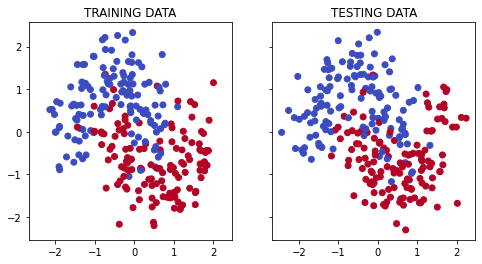

In [5]:
d0, d1 = "train", "test"
plot_datas(X0=data[d0]["X"], y0=data[d0]["y"], title0=titlefy(d=d0),
           X1=data[d1]["X"], y1=data[d1]["y"], title1=titlefy(d=d1))
del d0, d1

# "cheat" off a reference model

In [6]:
d = "train"
ref_model = RefNN(hidden_layer_sizes=LAYER_SZ, activation="logistic",
                  solver="lbfgs", max_iter=2048, random_state=1337).fit(X=data[d]["X"], y=data[d]["y"])
del d

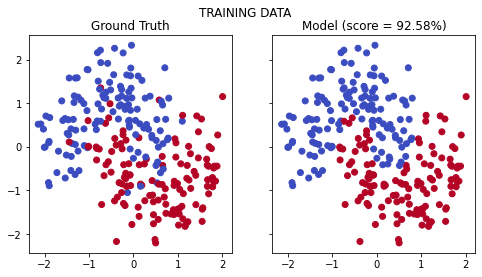

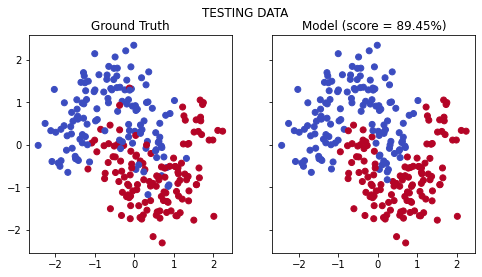

In [7]:
plot_perfs(pred_fn=ref_model.predict)

## replicate

In [8]:
model = homebrewify(ref_nn=ref_model)
model

_bias_          0          1          2          3
0 0   0.873385   3.944629  -0.841650        NaN        NaN
  1  22.316308 -12.993556  16.603979        NaN        NaN
  2 -25.552951  30.081200 -11.800556        NaN        NaN
  3  -1.068344   4.525354  -0.518800        NaN        NaN
1 0 -25.782396  -9.737237  25.080410 -40.164008  51.412467
  1  25.630496  18.716913 -33.278286  50.685572  -9.136564
  2  15.599658   7.432398  -6.167783  11.372810  -1.191241
2 0  -3.980336  74.614951 -54.646973 -16.600309        NaN
  1   3.980336 -74.614951  54.646973  16.600309        NaN

In [9]:
"""
check that our final layer's (pre-squash) outgoing activation is already a well-formed PMF,
thereby "proving" that we did the arithmetic correctly in transforming sklearn's
single-output-neuron format for binary classification to our 2-output-neuron format
"""
for d in "train", "test":
    # take the features dataframe
    data[d]["X"].apply(
        # forward-propagate (but don't squash) each observation i.e. row
        lambda x: fann.__fprop(x=x, nn=model), axis="columns").apply(
        # check that each result is a well-formed PMF
        util.check_pmf, axis="columns")
    del d

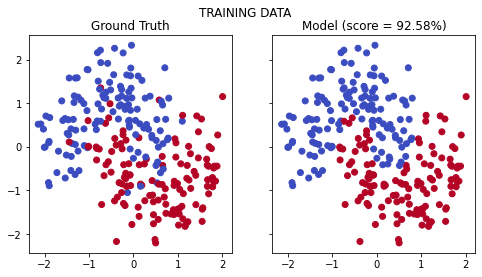

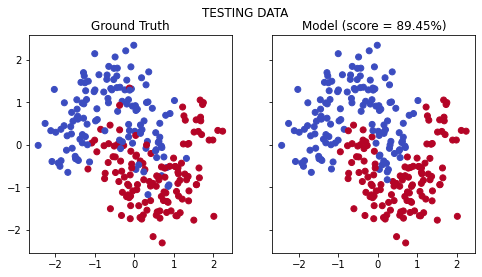

In [10]:
plot_perfs(pred_fn=lambda X: fann.predict(X=X, nn=model))

# `TODO(sparshsah)`

- fn's to check/convert to one-hot
- loss takes in 1hot y, one-liner linalg -> neg log geom mean likelihood
- write unit tests
- write backprop
- train our own homebrew model from scratch